# Attention for Vision Transformers, Explained

*Since their introduction in 2017 with* Attention is All You Need¹, *transformers have established themselves as the state of the art for natural language processing (NLP). In 2021,* An Image is Worth 16x16 Words *successfully adapted transformers for computer vision tasks. Since then, numerous transformer-based architectures have been proposed for computer vision.*

**This article takes an in-depth look to how an attention layer works in the context of computer vision. We'll cover both single-headed and multi-headed attention. It includes open-source code for the attention layers, as well as conceptual explanations of underlying mathematics. The code uses the PyTorch Python package.**

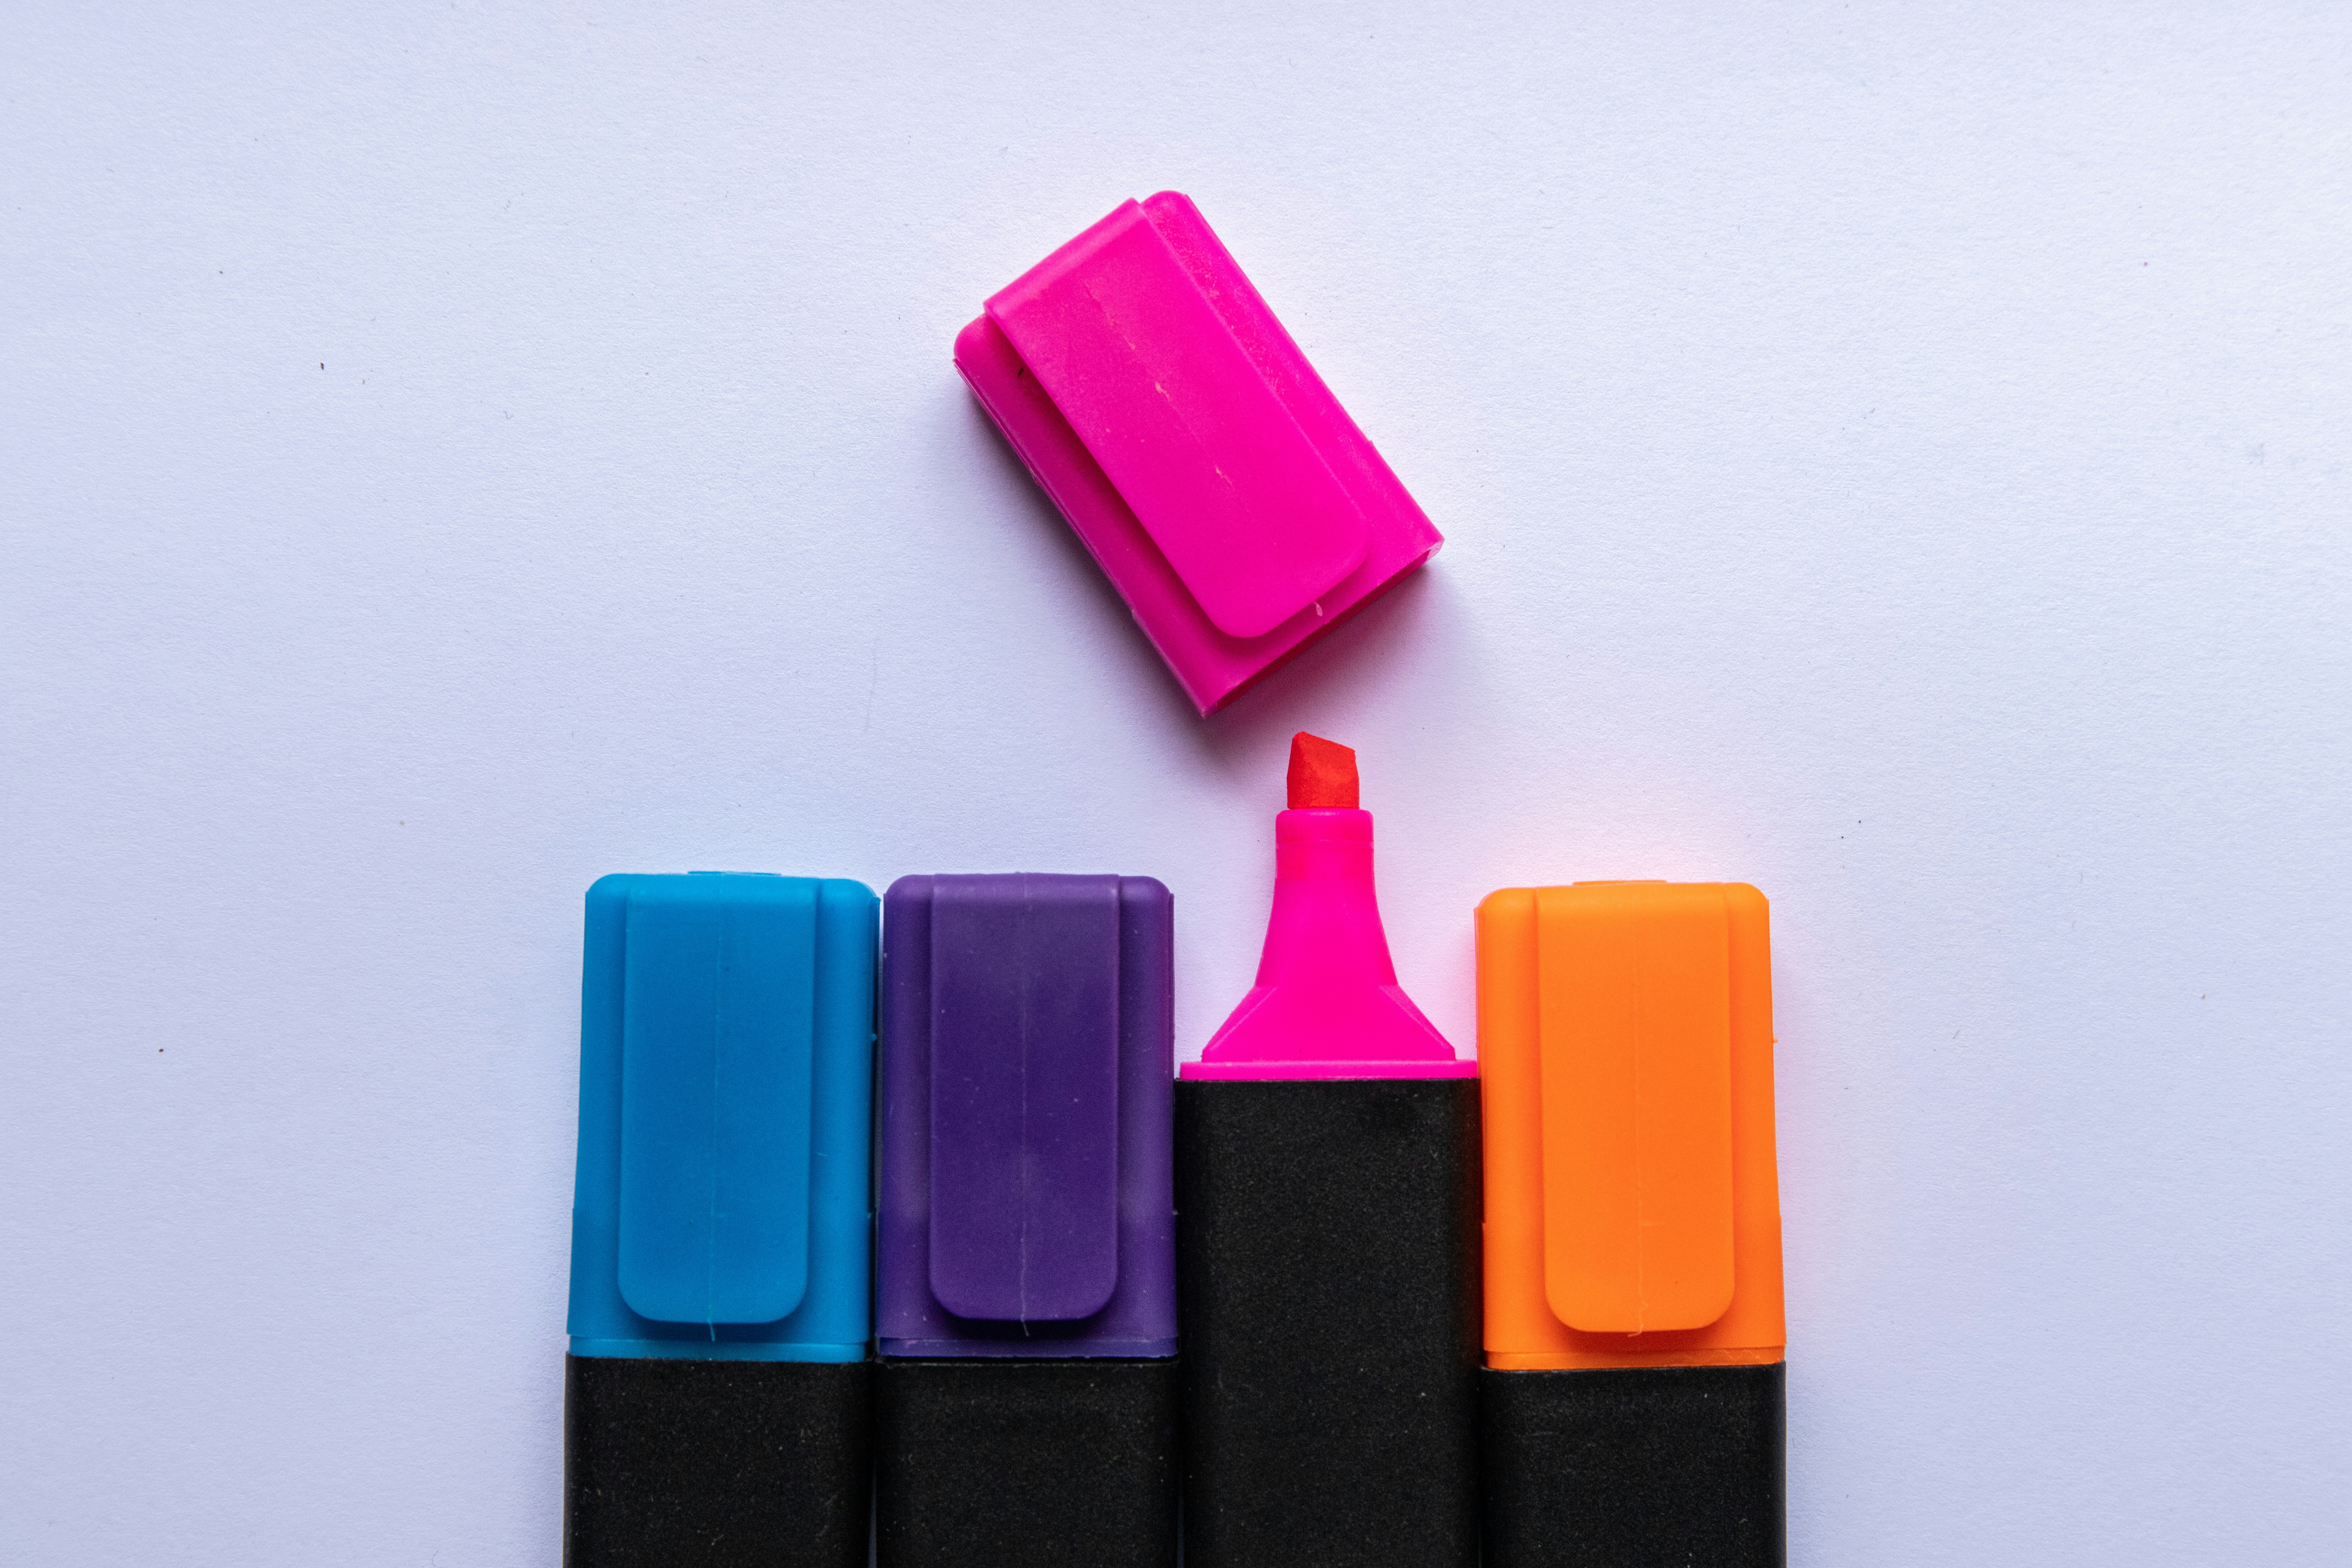

Photo by <a href="https://unsplash.com/@mitchel3uo?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Mitchell Luo</a> on <a href="https://unsplash.com/photos/pink-and-purple-plastic-case-NROHA1B-NYk?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

This article is part of a collection examining the internal workings of Vision Transformers in depth. Each of these articles is also available as a Jupyter Notebook with executable code. The other articles in the series are:
 - Vision Transformers, Explained
    - Jupyter Notebook
 - Attention for Vision Transformers, Explained
      - **Jupyter Notebook**
 - Position Embeddings for Vision Transformers, Explained
      - Jupyter Notebook
 - Tokens-to-Token Vision Transformers, Explained
      - Jupyter Notebook
 - GitHub Repository for Vision Transformers, Explained Series

In [1]:
import os
import copy
import math
import typing
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import timm.layers as timmm 

In [2]:
NoneFloat = typing.Union[None, float]

## Attention in General

For NLP applications, attention is often described as the relationship between words (tokens) in a sentence. In a computer vision application, attention looks at the relationships between patches (tokens) in an image. 

There are multiple ways to break an image down into a series of tokens. The original ViT² segments an image into *patches* that are then flattened into *tokens*; for a more in-depth explanation of this patch tokenization see TK. The *Tokens-to-Token ViT*³ develops a more complicated method of creating tokens from an image; more about that methodology can be found TK. 

This article will proceed though an attention layer assuming tokens as input. At the beginning of a transformer, the tokens will be representative of patches in the input image. However, deeper attention layers will compute attention on tokens that have been modified by preceding layers, removing the directness of the representation.

This article examines dot-product (equivalently multiplicative) attention as defined in *Attention is All You Need*¹. This is the same attention mechanism used in derivative works such as *An Image is Worth 16x16 Words8² and *Tokens-to-Token ViT*³. The code is based on the publicly available GitHub code for *Tokens-to-Token ViT*³ with some modifications. Changes to the source code include, but are not limited to, consolidating the two attention modules into one and implementing multi-headed attention.

The attention module in full is shown below:

In [3]:
class Attention(nn.Module):
    def __init__(self, 
                dim: int,
                chan: int,
                num_heads: int=1,
                qkv_bias: bool=False,
                qk_scale: NoneFloat=None):

        """ Attention Module

            Args:
                dim (int): input size of a single token
                chan (int): resulting size of a single token (channels)
                num_heads(int): number of attention heads in MSA
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
        """

        super().__init__()

        ## Define Constants
        self.num_heads = num_heads
        self.chan = chan
        self.head_dim = self.chan // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5
        assert self.chan % self.num_heads == 0, '"Chan" must be evenly divisible by "num_heads".'

        ## Define Layers
        self.qkv = nn.Linear(dim, chan * 3, bias=qkv_bias)
        #### Each token gets projected from starting length (dim) to channel length (chan) 3 times (for each Q, K, V)
        self.proj = nn.Linear(chan, chan)

    def forward(self, x):
        B, N, C = x.shape
        ## Dimensions: (batch, num_tokens, token_len)

        ## Calcuate QKVs
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        #### Dimensions: (3, batch, heads, num_tokens, chan/num_heads = head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        ## Calculate Attention
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        #### Dimensions: (batch, heads, num_tokens, num_tokens)

        ## Attention Layer
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.chan)
        #### Dimensions: (batch, heads, num_tokens, chan)

        ## Projection Layers
        x = self.proj(x)

        ## Skip Connection Layer
        v = v.transpose(1, 2).reshape(B, N, self.chan)
        x = v + x     
        #### Because the original x has different size with current x, use v to do skip connection

        return x

## Single-Headed Attention

Starting with only one attention head, let's step through each line of the forward pass, and look at some matrix diagrams as we go. We're using 7∗7=49 as our starting token size, since that's the starting token size in the T2T-ViT models.³ We're using 64 channels because that's also the T2T-ViT default³. We're using 100 tokens because it's a nice number. We're using a batch size of 13 because it's prime and won't be confused for any of the other parameters.

In [4]:
# Define an Input
token_len = 7*7
channels = 64
num_tokens = 100
batch = 13
x = torch.rand(batch, num_tokens, token_len)
B, N, C = x.shape
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

# Define the Module
A = Attention(dim=token_len, chan=channels, num_heads=1, qkv_bias=False, qk_scale=None)
A.eval();

Input dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49


From *Attention is All You Need*¹, attention is defined in terms of **Q**ueries, **K**eys, and **V**alues matrices. The first step is to calculate these through a learnable linear layer. The boolean *qkv_bias* term indicates if these linear layers have a bias term or not. This step also changes the length of the tokens from the input 49 to the *chan* parameter, which we set as 64.

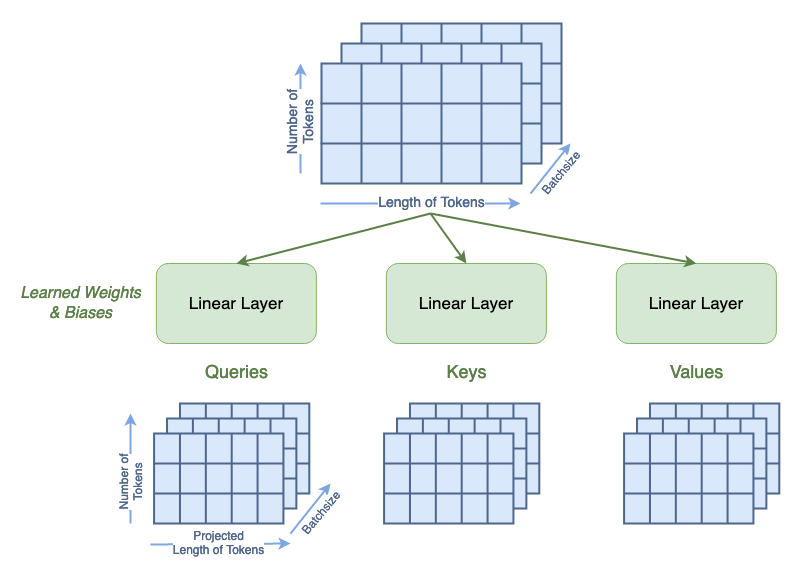

In [5]:
qkv = A.qkv(x).reshape(B, N, 3, A.num_heads, A.head_dim).permute(2, 0, 3, 1, 4)
q, k, v = qkv[0], qkv[1], qkv[2]
print('Dimensions for Queries are\n\tbatchsize:', q.shape[0], '\n\tattention heads:', q.shape[1], '\n\tnumber of tokens:', q.shape[2], '\n\tnew length of tokens:', q.shape[3])
print('See that the dimensions for queries, keys, and values are all the same:')
print('\tShape of Q:', q.shape, '\n\tShape of K:', k.shape, '\n\tShape of V:', v.shape)

Dimensions for Queries are
	batchsize: 13 
	attention heads: 1 
	number of tokens: 100 
	new length of tokens: 64
See that the dimensions for queries, keys, and values are all the same:
	Shape of Q: torch.Size([13, 1, 100, 64]) 
	Shape of K: torch.Size([13, 1, 100, 64]) 
	Shape of V: torch.Size([13, 1, 100, 64])


Now, we can start to compute attention, which is defined in as:

$$Attention(Q, K, V) = softmax(\frac{Q*K^T}{\sqrt{d_k}})*V$$

where $Q$, $K$, $V$, are the queries, keys, and values, respectively; and $d_k$ is the dimension of the keys, which is equal to the length of the key tokens and equal to the *chan* length.

We're going to go through this equation as it is implemented in the code. We'll call the intermediate matrices **A**ttn.

The first step is to compute:

$$\frac{Q*K^T}{\sqrt{d_k}} = A$$

In the code, we set

$$qk\_scale = \frac{1}{\sqrt{d_k}}$$

By default,

$$qk\_scale = \frac{1}{\sqrt{d_k}} = chan^{-0.5}$$

However, the user can specify an alternative scale value as a hyperparameter.

The matrix multiplication Q·Kᵀ in the numerator looks like this:

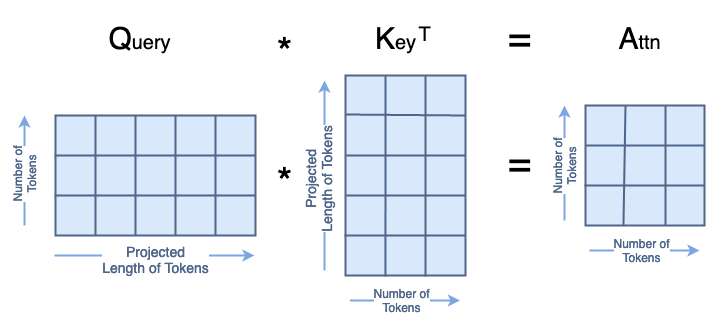

All of that together in code looks like:

In [6]:
attn = (q * A.scale) @ k.transpose(-2, -1)
print('Dimensions for Attn are\n\tbatchsize:', attn.shape[0], '\n\tattention heads:', attn.shape[1], '\n\tnumber of tokens:', attn.shape[2], '\n\tnumber of tokens:', attn.shape[3])

Dimensions for Attn are
	batchsize: 13 
	attention heads: 1 
	number of tokens: 100 
	number of tokens: 100


Next, we calculate the softmax of $A$, which doesn't change it's shape.

In [7]:
attn = attn.softmax(dim=-1)
print('Dimensions for Attn are\n\tbatchsize:', attn.shape[0], '\n\tattention heads:', attn.shape[1], '\n\tnumber of tokens:', attn.shape[2], '\n\tnumber of tokens:', attn.shape[3])

Dimensions for Attn are
	batchsize: 13 
	attention heads: 1 
	number of tokens: 100 
	number of tokens: 100


Finally, we compute $A*V=x$, which looks like:

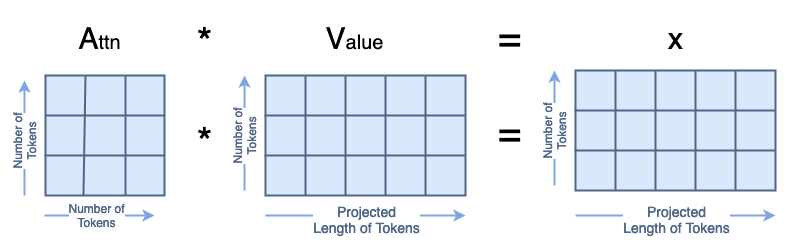

In [8]:
x = attn @ v
print('Dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tattention heads:', x.shape[1], '\n\tnumber of tokens:', x.shape[2], '\n\tlength of tokens:', x.shape[3])

Dimensions for x are
	batchsize: 13 
	attention heads: 1 
	number of tokens: 100 
	length of tokens: 64


The output $x$ is reshaped to remove the attention head dimension.

In [9]:
x = x.transpose(1, 2).reshape(B, N, A.chan)
print('Dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\tlength of tokens:', x.shape[2])

Dimensions for x are
	batchsize: 13 
	number of tokens: 100 
	length of tokens: 64


We then feed $x$ through a learnable linear layer that does not change it's shape.

In [10]:
x = A.proj(x)
print('Dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\tlength of tokens:', x.shape[2])

Dimensions for x are
	batchsize: 13 
	number of tokens: 100 
	length of tokens: 64


Lastly, we implement a skip connection. Since the current shape of $x$ is different from the input shape of $x$, we use $V$ for the skip connection. We do flatten $V$ in the attention head dimension.

In [11]:
orig_shape = (batch, num_tokens, token_len)
curr_shape = (x.shape[0], x.shape[1], x.shape[2])
v = v.transpose(1, 2).reshape(B, N, A.chan)
v_shape = (v.shape[0], v.shape[1], v.shape[2])
print('Original shape of input x:', orig_shape)
print('Current shape of x:', curr_shape)
print('Shape of V:', v_shape)
x = v + x     
print('After skip connection, dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\tlength of tokens:', x.shape[2])

Original shape of input x: (13, 100, 49)
Current shape of x: (13, 100, 64)
Shape of V: (13, 100, 64)
After skip connection, dimensions for x are
	batchsize: 13 
	number of tokens: 100 
	length of tokens: 64


That completes the attention layer!

## Multi-Headed Attention

Now that we've looked at single headed attention, we can expand to multi-headed attention. In the context of computer vision, this is often called **M**ulti-headed **S**elf **A**ttention (MSA). This section isn't going to go through all the steps in as much detail; instead, we'll focus on the places where the matrix shapes differ.

Same as for a single attention head, we're using 7∗7=49 as our starting token size and 64 channels because that's the T2T-ViT default³. We're using 100 tokens because it's a nice number. We're using a batch size of 13 because it's prime and won't be confused for any of the other parameters.

The number of attention heads must evenly divide the number of channels, so for this example we'll use 4 attention heads.

In [12]:
# Define an Input
token_len = 7*7
channels = 64
num_tokens = 100
batch = 13
num_heads = 4
x = torch.rand(batch, num_tokens, token_len)
B, N, C = x.shape
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

# Define the Module
MSA = Attention(dim=token_len, chan=channels, num_heads=num_heads, qkv_bias=False, qk_scale=None)
MSA.eval();

Input dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49


The process to computer the **Q**ueries, **K**eys, and **V**alues remains the same as in single-headed attention. However, you can see that the new length of the tokens is $\frac{chan}{num\_heads}$. The total size of the $Q$, $K$, and $V$ matrices have not changed; their contents are just distributed across the head dimension. You can think abut this as segmenting the single headed matrix for the multiple heads:

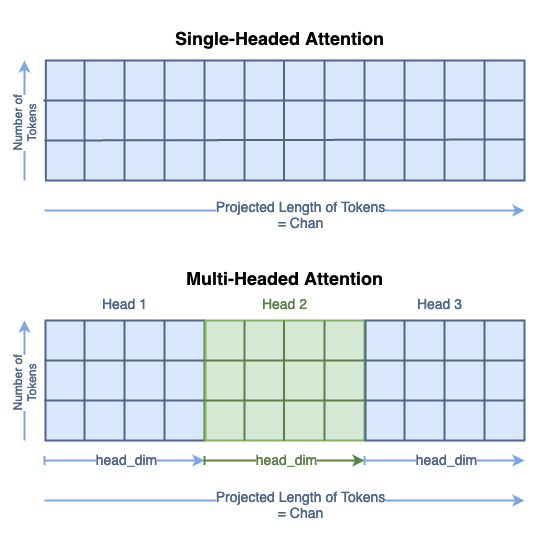

We'll denote the submatrices as $Q_{Hi}$ for **Q**uery **H**ead **i**.

In [13]:
qkv = MSA.qkv(x).reshape(B, N, 3, MSA.num_heads, MSA.head_dim).permute(2, 0, 3, 1, 4)
q, k, v = qkv[0], qkv[1], qkv[2]
print('Head Dimension = chan / num_heads =', MSA.chan, '/', MSA.num_heads, '=', MSA.head_dim)
print('Dimensions for Queries are\n\tbatchsize:', q.shape[0], '\n\tattention heads:', q.shape[1], '\n\tnumber of tokens:', q.shape[2], '\n\tnew length of tokens:', q.shape[3])
print('See that the dimensions for queries, keys, and values are all the same:')
print('\tShape of Q:', q.shape, '\n\tShape of K:', k.shape, '\n\tShape of V:', v.shape)

Head Dimension = chan / num_heads = 64 / 4 = 16
Dimensions for Queries are
	batchsize: 13 
	attention heads: 4 
	number of tokens: 100 
	new length of tokens: 16
See that the dimensions for queries, keys, and values are all the same:
	Shape of Q: torch.Size([13, 4, 100, 16]) 
	Shape of K: torch.Size([13, 4, 100, 16]) 
	Shape of V: torch.Size([13, 4, 100, 16])


The next step is to compute

$$\frac{Q_{hi}*K^T_{hi}}{\sqrt{d_k}} = A_{Hi}$$

for every head $i$. In this context, the length of the keys is

$$d_k = \frac{chan}{num\_heads}$$

As in single headed attention, we use the default

$$qk\_scale = \frac{1}{\sqrt{d_k}}$$

though the user can specify an alternative scale value as a hyperparameter.
 
We end this step with *num_heads* = 4 different **A**ttn matrices, which looks like:

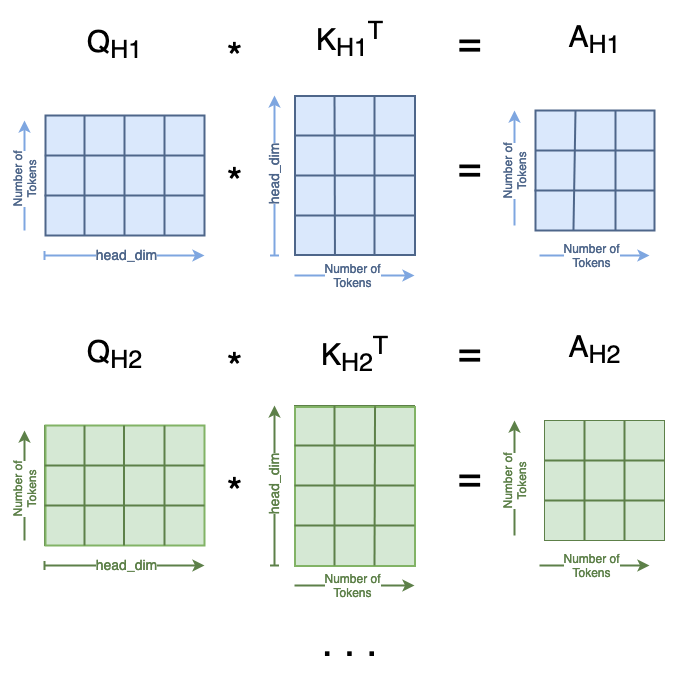

In [14]:
attn = (q * MSA.scale) @ k.transpose(-2, -1)
print('Dimensions for Attn are\n\tbatchsize:', attn.shape[0], '\n\tattention heads:', attn.shape[1], '\n\tnumber of tokens:', attn.shape[2], '\n\tnumber of tokens:', attn.shape[3])

Dimensions for Attn are
	batchsize: 13 
	attention heads: 4 
	number of tokens: 100 
	number of tokens: 100


Next we calculate the softmax of $A$, which doesn't change it's shape.

Then, we can compute

$$A_{Hi} * V_{Hi} = x_{Hi}$$

This is similarly distributed across the multiple attention heads:

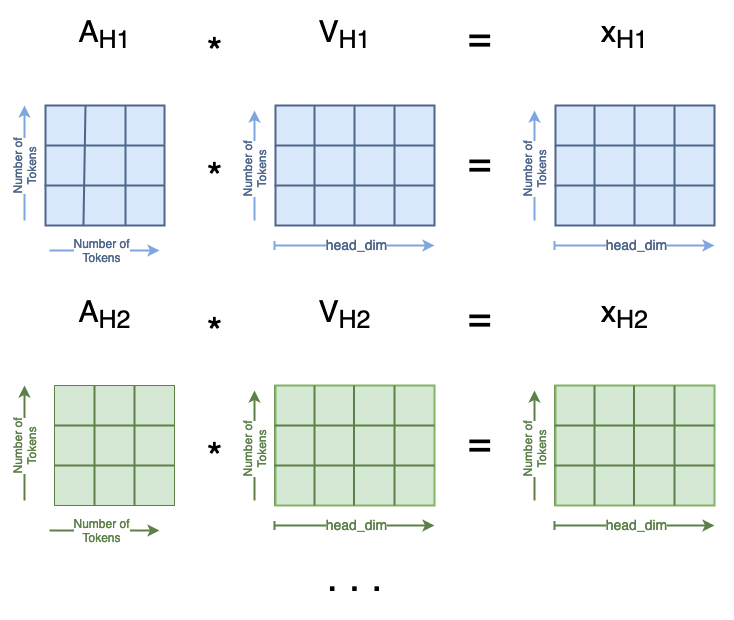

In [15]:
attn = attn.softmax(dim=-1)

x = attn @ v
print('Dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tattention heads:', x.shape[1], '\n\tnumber of tokens:', x.shape[2], '\n\tlength of tokens:', x.shape[3])

Dimensions for x are
	batchsize: 13 
	attention heads: 4 
	number of tokens: 100 
	length of tokens: 16


Now we concatenate all of the $x_{Hi}$'s together through some reshaping. This is the inverse operation from the first step:

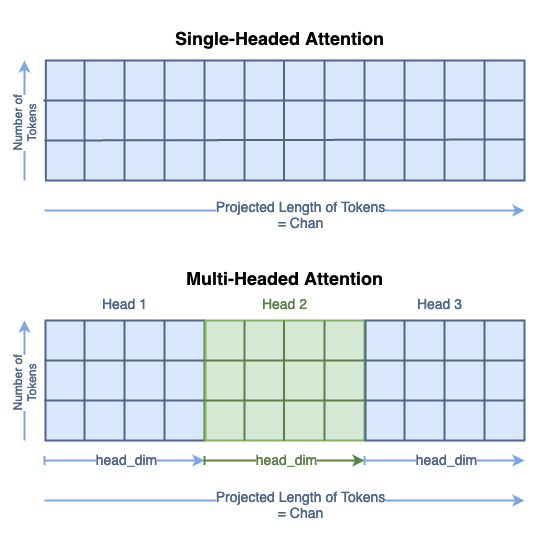

In [16]:
x = x.transpose(1, 2).reshape(B, N, MSA.chan)
print('Dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\tlength of tokens:', x.shape[2])

Dimensions for x are
	batchsize: 13 
	number of tokens: 100 
	length of tokens: 64


Now that we've concatenated all of the heads back together, the rest of the Attention module remains unchanged. For the skip connection, we still use $V$, but we have to reshape it to remove the head dimension.

In [17]:
x = MSA.proj(x)
print('Dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\tlength of tokens:', x.shape[2])

orig_shape = (batch, num_tokens, token_len)
curr_shape = (x.shape[0], x.shape[1], x.shape[2])
v = v.transpose(1, 2).reshape(B, N, A.chan)
v_shape = (v.shape[0], v.shape[1], v.shape[2])
print('Original shape of input x:', orig_shape)
print('Current shape of x:', curr_shape)
print('Shape of V:', v_shape)
x = v + x     
print('After skip connection, dimensions for x are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\tlength of tokens:', x.shape[2])

Dimensions for x are
	batchsize: 13 
	number of tokens: 100 
	length of tokens: 64
Original shape of input x: (13, 100, 49)
Current shape of x: (13, 100, 64)
Shape of V: (13, 100, 64)
After skip connection, dimensions for x are
	batchsize: 13 
	number of tokens: 100 
	length of tokens: 64


And that concludes multi-headed attention!

## Conclusion

We've now walked through every step of an attention layer as implemented for vision transformers. The learnable weights in an attention layer are found in the first projection from tokens to queries, keys, and values and in the final projection. The majority of the attention layer is deterministic matrix multiplication. However, the linear layers can contain large numbers of weights when long tokens are used. The number of weights in the QKV projection layer are equal to $input\_token\_len*chan*3$, and the number of weights in the final projection layer are equal to $chan^2$.

To use the attention layers, you can create custom attention layers (as done here!), or use attention layers included in machine learning packages. The GitHub with the code from this article is TK. PyTorch also has `torch.nn.MultiheadedAttention()`⁴ layers, which compute attention as defined above. Happy attending!

### Further Reading

To learn more about attention layers in NLP contexts, see
 - Transformers Explained Visually Part 1 Overview of Functionality: https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452
 - Transformers Explained Visually Part 2 How it Works, Step by Step: https://towardsdatascience.com/transformers-explained-visually-part-2-how-it-works-step-by-step-b49fa4a64f34
 - Transformers Explained Visually Part 3 Multi-Headed Attention Deep Dive: https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853
 - Visual Guide to Transformer Neural Networks Multi-Head & Self Attention Video: https://www.youtube.com/watch?v=mMa2PmYJlCo

For a video lecture broadly about vision transformers (with relevant chapters noted), see
 - Vision Transformer and its Applications: https://youtu.be/hPb6A92LROc?si=GaGYiZoyDg0PcdSP
     - Human Visual Attention: 4:31 - 5:18 (https://youtu.be/hPb6A92LROc?t=271&si=VMx2lM9lvW-oKcW_)
     - Attention as a Dot Product: 5:18–6:14 (https://youtu.be/hPb6A92LROc?t=318&si=pF2SFp2XXjK8AWsL)
     - Description of Attention formula: 16:13–17:52 (https://youtu.be/hPb6A92LROc?si=toAgKQCOh9zGCR-c&t=973)
     - Why Multi-Head Self-Attention: 19:44–19:58 (https://youtu.be/hPb6A92LROc?t=1184&si=Sy1e149ukt99DoRf)

### Citations

[1] Vaswani et al (2017). Attention Is All You Need. https://doi.org/10.48550/arXiv.1706.03762

[2] Dosovitskiy et al (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. https://doi.org/10.48550/arXiv.2010.11929

[3] Yuan et al (2021). Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet. https://doi.org/10.48550/arXiv.2101.11986
 - GitHub code: https://github.com/yitu-opensource/T2T-ViT

[4] PyTorch. Multiheaded Attention. https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html